In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import unet_model as UNET
import cv2
import csv
from helper import load_obj
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv

import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')
#torch.backends.cudnn.benchmark = False

# Hyperparameter

In [2]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    'batch_size':2 * torch.cuda.device_count(),
    'test_batch_size':2 * torch.cuda.device_count(),
    'input_size':256,
    'resize_scale':280,
    'rot':True,
    'crop_size':256,
    'fliplr':False,
    #model params
    'epoch_count':1,
    'epochs':100,
    'log_interval':1000,
    'lr':0.0003,
    'ngf':64,
    'dataroot':'D:/crane2',
}

Num_GPU : 4


# Utils

In [3]:
def to_np(x):
    return x.data.cpu().numpy()
        
def plot_train_result(test_image, epoch, save=False,  show=True, fig_size=(15, 15)):
    plt.figure(figsize=fig_size)
    imgs = [to_np(test_image[0]), to_np(test_image[1]), test_image[2], to_np(test_image[3]), test_image[4],
           to_np(test_image[5]), test_image[6]]
    title = ["Test Image", "Test Mask", "Predicted Mask", "Test U Mask", "Predicted U Mask", "Test V Mask", "Predicted V Mask"]
        
    plt.subplot(1, 7, 1)
    plt.title(title[0])
    img = imgs[0]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 7, 2)
    plt.title(title[1])
    img = imgs[1]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min()))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 7, 3)
    plt.title(title[2])
    img = imgs[2]
    img = img.squeeze()
    img = to_np(torch.argmax(img, dim=0))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 7, 4)
    plt.title(title[3])
    img = imgs[3]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min()))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 7, 5)
    plt.title(title[4])
    img = imgs[4]
    img = img.squeeze()
    img = to_np(torch.argmax(img, dim=0))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 7, 6)
    plt.title(title[5])
    img = imgs[5]
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min()))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 7, 7)
    plt.title(title[6])
    img = imgs[6]
    img = img.squeeze()
    img = to_np(torch.argmax(img, dim=0))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # save figure
    if save:
        save_fn = './img_per_epoch/epoch_{:d}'.format(epoch+1) + '.png'
        fig.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

# Model

In [4]:
class correspondence_block(nn.Module):
    def __init__(self, d=64):
        super(correspondence_block,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(d)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(d)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(d*2)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(d*2)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(d*2)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(d*2)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(d*4)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(d*4)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(params['input_size']/16)*int(params['input_size']/16)*d*8, d*4)
        self.fc2 = nn.Linear(d*4,int(params['input_size']/16)*int(params['input_size']/16)*d*4)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(d*2)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(d*4, d*4, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(d*4)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(d*2)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(d*4, d*4, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(d*4)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(d*4, d, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(d)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(d*2, d*2, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(d*2)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(d*2, 2, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(d*2, 256, 5, 2, 2, 1)
        self.conv17 = nn.ConvTranspose2d(d*2, 256, 5, 2, 2, 1)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x128x128
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x128x128
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x128x128
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x64x64
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x64x64

        f2 = torch.cat((f2_1, f2_2), 1) #256x64x64
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x32x32
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x32x32
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x32x32

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x16x16

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #512
        
        d1 = self.fc2(encode) #256x16x16
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(params['input_size']/16),int(params['input_size']/16))))) #128x32x32
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x32x32
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x32x32
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x64x64
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x64x64
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x64x64
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x128x128
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x128x128
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x128x128

        mask = self.conv15(d3_uni) #256x256x256
        u_mask = self.conv16(d3_uni) #256x256x256
        v_mask = self.conv17(d3_uni) #256x256x256
        
        return mask, u_mask, v_mask
    
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [5]:
model = correspondence_block(params['ngf'])
model.weight_init(mean=0.0, std=0.02)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): correspondence_block(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv5): Conv2d(256, 128, kernel

# Preprocess

In [6]:
train_image_paths = glob(params['dataroot'] + '/image_coco_512_aug/*.png')[4001:]
train_mask_paths = glob(params['dataroot'] + '/mask_coco_512/*.png')[4001:]
train_u_mask_paths = glob(params['dataroot'] + '/U_mask_coco_512/*.png')[4001:]
train_v_mask_paths = glob(params['dataroot'] + '/V_mask_coco_512/*.png')[4001:]

val_image_paths = glob(params['dataroot'] + '/image_coco_512_aug/*.png')[:4001]
val_mask_paths = glob(params['dataroot'] + '/mask_coco_512/*.png')[:4001]
val_u_mask_paths = glob(params['dataroot'] + '/U_mask_coco_512/*.png')[:4001]
val_v_mask_paths = glob(params['dataroot'] + '/V_mask_coco_512/*.png')[:4001]

test_image_paths = glob(params['dataroot'] + '/real_image/*.png')
test_mask_paths = glob(params['dataroot'] + '/real_mask/*.png')

In [7]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, mask_dir, u_mask_dir, v_mask_dir, transform=None, resize_scale=None, rot=None, crop_size=None,
                 fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.image_path = image_dir
        self.mask_path = mask_dir
        self.u_mask_path = u_mask_dir
        self.v_mask_path = v_mask_dir
        
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.rot = rot
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = self.image_path[index]
        mask_fn = self.mask_path[index]
        u_mask_fn = self.u_mask_path[index]
        v_mask_fn = self.v_mask_path[index]
        
        img = cv2.imread(img_fn)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_fn, cv2.IMREAD_GRAYSCALE)
        u_mask = cv2.imread(u_mask_fn, cv2.IMREAD_GRAYSCALE)
        v_mask = cv2.imread(v_mask_fn, cv2.IMREAD_GRAYSCALE)
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img = cv2.resize(img, (self.resize_scale, self.resize_scale), cv2.INTER_CUBIC)
            mask = cv2.resize(mask, (self.resize_scale, self.resize_scale), cv2.INTER_CUBIC)
            u_mask = cv2.resize(u_mask, (self.resize_scale, self.resize_scale), cv2.INTER_CUBIC)
            v_mask = cv2.resize(v_mask, (self.resize_scale, self.resize_scale), cv2.INTER_CUBIC)
                   
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size)
            y = random.randint(0, self.resize_scale - self.crop_size)
            img = img[x:x + self.crop_size, y:y + self.crop_size]
            mask = mask[x:x + self.crop_size, y:y + self.crop_size]
            u_mask = u_mask[x:x + self.crop_size, y:y + self.crop_size]
            v_mask = v_mask[x:x + self.crop_size, y:y + self.crop_size]
        
        if self.rot:
            height, width, channel = img.shape
            temp_img = img
            angle = random.randint(-15, 15)
            matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
            img = cv2.warpAffine(img, matrix, (width, height))
            for i in range(height):
                for j in range(width):
                    if img[i,j,0]==0 and img[i,j,1]==0 and img[i,j,2]==0:
                        img[i,j]=temp_img[i,j]
            mask = cv2.warpAffine(mask, matrix, (width, height))
            u_mask = cv2.warpAffine(u_mask, matrix, (width, height))
            v_mask = cv2.warpAffine(v_mask, matrix, (width, height))
        
        if self.fliplr:
            if random.random() < 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)
                u_mask = cv2.flip(u_mask, 1)
                v_mask = cv2.flip(v_mask, 1)
        
        mask = np.where(mask>0,1.0,0)
               
        if self.transform is not None:
            img = self.transform(img)
        
        else:
            transform = transforms.ToTensor()
            img = transform(img)
        
        mask = (torch.from_numpy(mask)).type(torch.double)
        u_mask = (torch.from_numpy(u_mask)).type(torch.int64)
        v_mask = (torch.from_numpy(v_mask)).type(torch.int64)        
        
        return img, mask, u_mask, v_mask
                                              
    def __len__(self):
        return len(self.image_path)

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.ToPILImage(),
                                transforms.ColorJitter(brightness=(0.2,1), contrast=(0.3,2), saturation=(0.2,2), hue=(-0.1,0.1)),
                                transforms.ToTensor()])

train_data = DatasetFromFolder(train_image_paths, train_mask_paths, train_u_mask_paths, train_v_mask_paths, transform=transform,
                               resize_scale=params['resize_scale'], rot=params['rot'], crop_size=params['crop_size'],
                               fliplr=params['fliplr'])
train_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=params['batch_size'], shuffle=True)

val_data = DatasetFromFolder(val_image_paths, val_mask_paths, val_u_mask_paths, val_v_mask_paths, transform=None,
                             resize_scale=params['input_size'])
val_data_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=params['test_batch_size'], shuffle=False)

In [9]:
for i, (data, mask, u_mask, v_mask) in enumerate(train_data_loader):
    if i == 0:
        print(data[0].shape, mask[0].shape, u_mask[0].shape, v_mask[0].shape)
        break

torch.Size([3, 256, 256]) torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256])


(-0.5, 255.5, 255.5, -0.5)

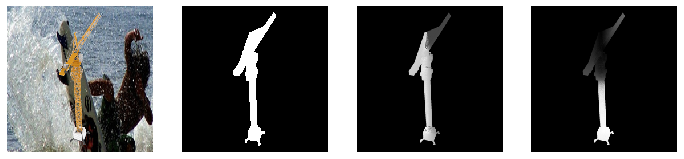

In [10]:
# Get specific val images
val_image, val_mask, val_u_mask, val_v_mask = val_data.__getitem__(5) # Convert to 4d tensor (BxNxHxW)
val_image = val_image.unsqueeze(0)

val_data_image = ((val_image - val_image.min()) / (val_image.max() - val_image.min()))

plt.figure(figsize=(12,12))
plt.subplot(1,4,1)
plt.imshow(val_data_image[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(val_mask,'gray')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(val_u_mask,'gray')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(val_v_mask,'gray')
plt.axis('off')

# Optimization

In [11]:
# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=3e-5)
criterion_m = nn.CrossEntropyLoss()
criterion_u = nn.CrossEntropyLoss()
criterion_v = nn.CrossEntropyLoss()

# Visualization

In [12]:
def visualization(model, test_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([transforms.ToTensor()])

    image = cv2.imread(test_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (params['input_size'], params['input_size']), cv2.INTER_CUBIC)
    image= transform(image).unsqueeze_(0)
    mask, u_mask, v_mask = model(image)

    mask = mask.squeeze()
    mask_out = to_np(torch.argmax(mask, dim=0))
    
    u_mask = u_mask.squeeze()
    u_mask_out = to_np(torch.argmax(u_mask, dim=0))   
    
    v_mask = v_mask.squeeze()
    v_mask_out = to_np(torch.argmax(v_mask, dim=0)) 
    
    test_image = plt.imread(test_path)
    
    plt.figure(figsize=(12,12))
    display_list = [test_image, mask_out, u_mask_out, v_mask_out]
    title = ['Input Image', 'Predicted Mask', 'Predicted U Mask', 'Predicted V Mask']
       
    plt.subplot(1, 4, 1)
    plt.title(title[0])
    plt.imshow(display_list[0])
    plt.axis('off')
        
    plt.subplot(1, 4, 2)
    plt.title(title[1])
    plt.imshow(display_list[1], 'gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title(title[2])
    plt.imshow(display_list[2], 'gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title(title[3])
    plt.imshow(display_list[3], 'gray')
    plt.axis('off') 
    
    plt.show()

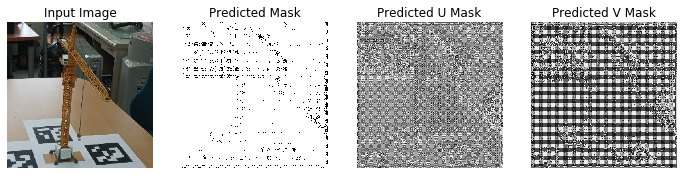

In [13]:
test_path = 'D:/crane2/real_image_crop/creal_0065.png'
visualization(model, test_path)

# Training

In [14]:
checkpoint_path = './checkpoints/cpb_pix2pose_aug'

In [ ]:
train_avg_mask_losses = []
val_avg_mask_losses = []
train_avg_u_mask_losses = []
val_avg_u_mask_losses = []
train_avg_v_mask_losses = []
val_avg_v_mask_losses = []


for epoch in range(params['epoch_count'], params['epochs'] + 1):
    # train
    model.to(device).train()
    cut_num = 3000 # 1epoch = cut_num x batch_size
    
    train_mask_losses = []
    val_mask_losses = []
    train_u_mask_losses = []
    val_u_mask_losses = []
    train_v_mask_losses = []
    val_v_mask_losses = []
    
    for iteration, (batch) in enumerate(train_data_loader):
        
        image, mask, u_mask, v_mask = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
        mask_pred, u_mask_pred, v_mask_pred = model(image)

        optimizer.zero_grad()
 
        #loss
        loss_m = criterion_m(mask_pred.type(torch.double), mask.type(torch.long))
        loss_u = criterion_u(u_mask_pred.type(torch.double), u_mask)
        loss_v = criterion_v(v_mask_pred.type(torch.double), v_mask)
        loss = loss_m + loss_u + loss_v
        
        loss.backward()
        optimizer.step()
        
        # loss values
        train_mask_losses.append(loss_m.item())
        train_u_mask_losses.append(loss_u.item())
        train_v_mask_losses.append(loss_v.item())

        if iteration % params['log_interval'] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss_Mask: {:.4f}\tLoss_U_Mask: {:.4f}\tLoss_V_Mask: {:.4f}".format(
                epoch, params['epochs'],iteration, cut_num, loss_m.item(), loss_u.item(), loss_v.item()))
        
        if iteration == cut_num:
            break
        
    # avg loss values for plot
    train_avg_mask_loss = torch.mean(torch.FloatTensor(train_mask_losses)) 
    train_avg_u_mask_loss = torch.mean(torch.FloatTensor(train_u_mask_losses))
    train_avg_v_mask_loss = torch.mean(torch.FloatTensor(train_v_mask_losses))
    train_avg_mask_losses.append(train_avg_mask_loss.item())
    train_avg_u_mask_losses.append(train_avg_u_mask_loss.item())
    train_avg_v_mask_losses.append(train_avg_v_mask_loss.item())

    model.to(device).eval()
    
    with torch.no_grad():
        for iteration, (batch) in enumerate(val_data_loader):
            
            image, mask, u_mask, v_mask = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
            mask_pred, u_mask_pred, v_mask_pred = model(image)

            #loss
            loss_m = criterion_m(mask_pred.type(torch.double), mask.type(torch.long))
            loss_u = criterion_u(u_mask_pred.type(torch.double), u_mask)
            loss_v = criterion_v(v_mask_pred.type(torch.double), v_mask)
            loss = loss_m + loss_u + loss_v

            val_mask_losses.append(loss_m.item())
            val_u_mask_losses.append(loss_u.item())
            val_v_mask_losses.append(loss_v.item())
    
    # avg loss values for plot
    val_avg_mask_loss = torch.mean(torch.FloatTensor(val_mask_losses))
    val_avg_u_mask_loss = torch.mean(torch.FloatTensor(val_u_mask_losses))
    val_avg_v_mask_loss = torch.mean(torch.FloatTensor(val_v_mask_losses))
    val_avg_mask_losses.append(val_avg_mask_loss.item())
    val_avg_u_mask_losses.append(val_avg_u_mask_loss.item())
    val_avg_v_mask_losses.append(val_avg_v_mask_loss.item())
    
    print("Val_Loss_Mask: {:.4f}\tVal_U_Loss_Mask: {:.4f}\tVal_V_Loss_Mask: {:.4f}".format(val_avg_mask_loss.item(),
            val_avg_u_mask_loss.item(), val_avg_v_mask_loss.item()))
    
    # Show result for test image
    image = val_image.to(device)
    mask = val_mask.to(device)
    u_mask = val_u_mask.to(device)
    v_mask = val_v_mask.to(device)
    mask_pred, u_mask_pred, v_mask_pred = model(image)
    
    plot_train_result([image, mask, mask_pred, u_mask, u_mask_pred, v_mask, v_mask_pred], epoch, save=False)
    
    # Save weight
    if epoch % 1 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/cpb-%s.pt'%epoch)

===> Epoch[1/100](0/3000): Loss_Mask: 0.8600	Loss_U_Mask: 5.6677	Loss_V_Mask: 5.7654


In [17]:
print('Mask Loss :',np.array(val_avg_mask_losses).argmin()+1, val_avg_mask_losses[np.array(val_avg_mask_losses).argmin()],
      '\tU Mask Loss :',np.array(val_avg_u_mask_losses).argmin()+1, val_avg_u_mask_losses[np.array(val_avg_u_mask_losses).argmin()],
      '\tV Mask Loss :',np.array(val_avg_v_mask_losses).argmin()+1, val_avg_v_mask_losses[np.array(val_avg_v_mask_losses).argmin()])

Mask Loss : 158 0.01975219137966633 	U Mask Loss : 34 0.3858659267425537 	V Mask Loss : 61 0.3708331286907196


# Loss Curve

In [18]:
csvfile=open('./loss/train_u_mask_loss_cpb_pix2pose.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(train_avg_u_mask_losses).reshape(len(train_avg_u_mask_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

csvfile=open('./loss/val_u_mask_loss_cpb_pix2pose.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(val_avg_u_mask_losses).reshape(len(val_avg_u_mask_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()
                    
csvfile=open('./loss/train_v_mask_loss_cpb_pix2pose.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(train_avg_v_mask_losses).reshape(len(train_avg_v_mask_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

csvfile=open('./loss/val_v_mask_loss_cpb_pix2pose.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(val_avg_v_mask_losses).reshape(len(val_avg_v_mask_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

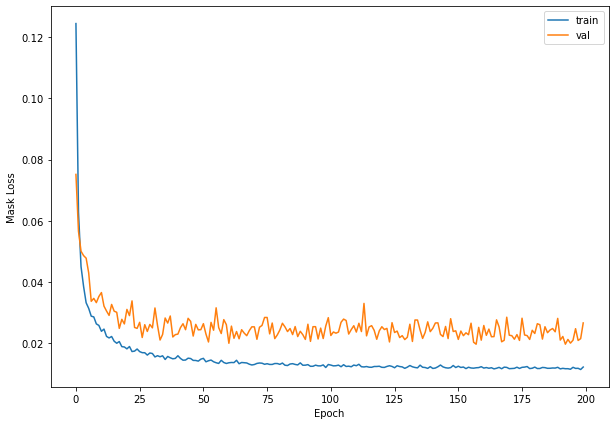

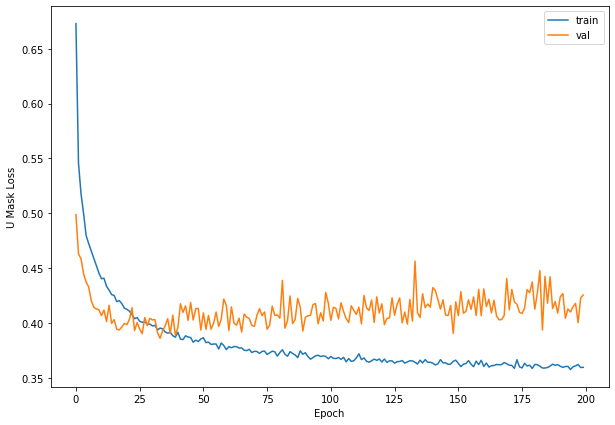

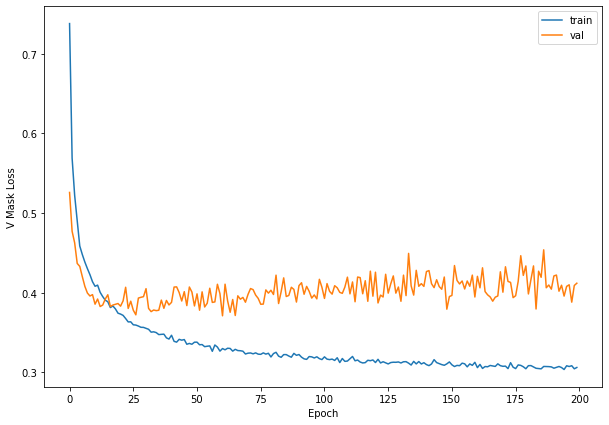

In [19]:
plt.figure(figsize=(10,7))
plt.plot(train_avg_mask_losses, label='train')
plt.plot(val_avg_mask_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Mask Loss')
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(train_avg_u_mask_losses, label='train')
plt.plot(val_avg_u_mask_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('U Mask Loss')
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(train_avg_v_mask_losses, label='train')
plt.plot(val_avg_v_mask_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('V Mask Loss')
plt.legend()

# Restore Checkpoint

In [20]:
weight_dict = torch.load(checkpoint_path+'/cpb-34.pt')

In [21]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

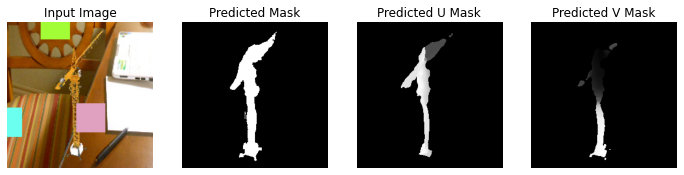

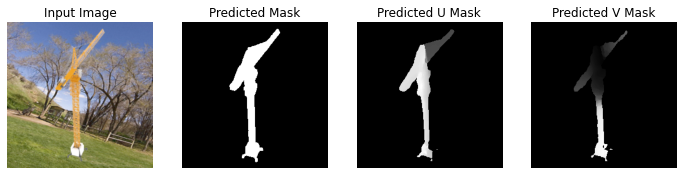

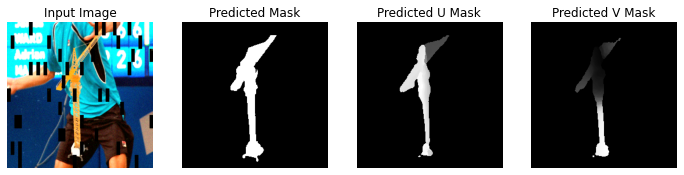

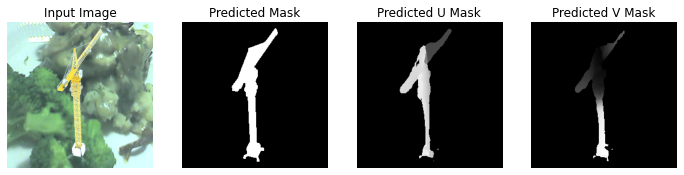

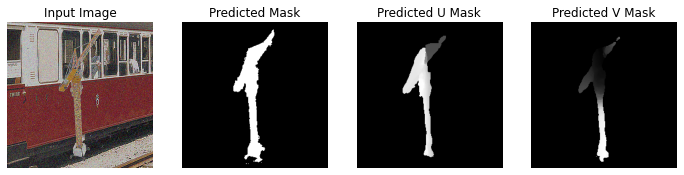

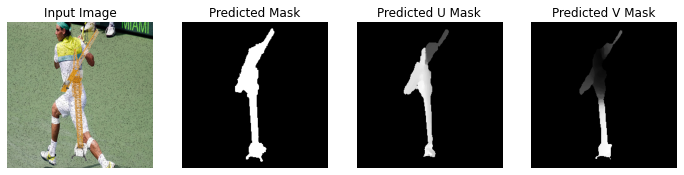

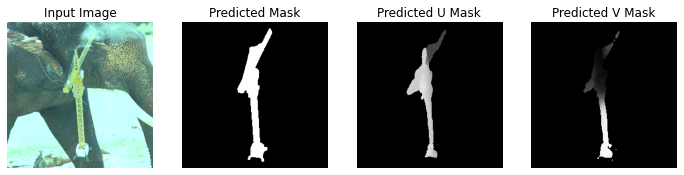

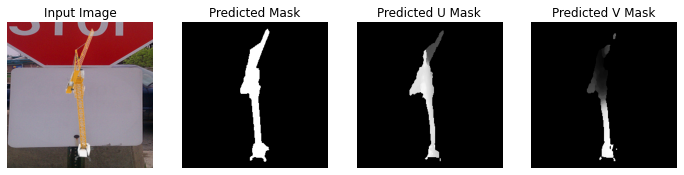

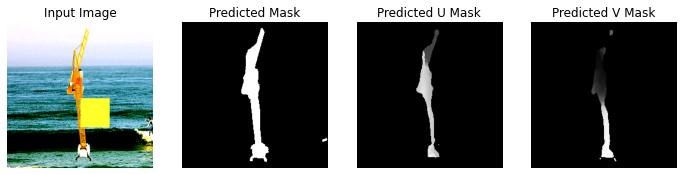

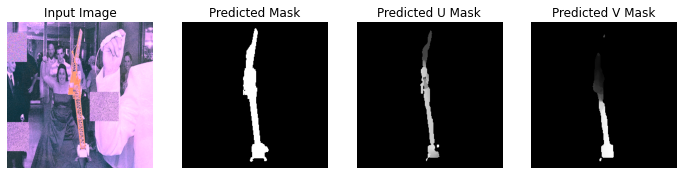

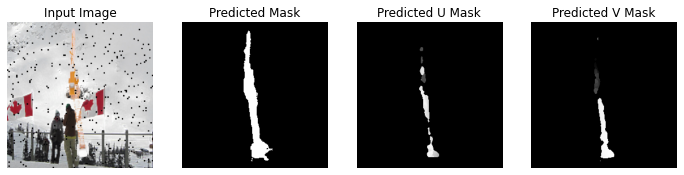

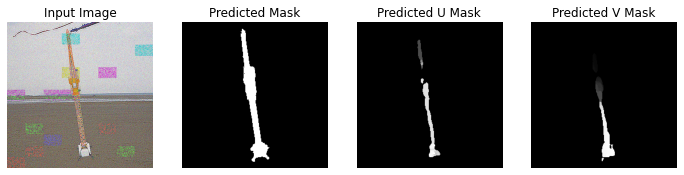

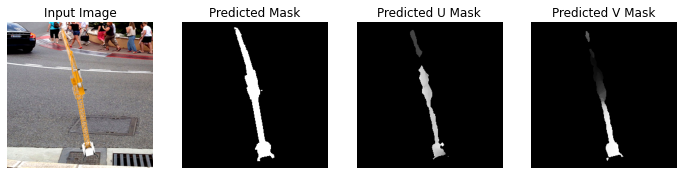

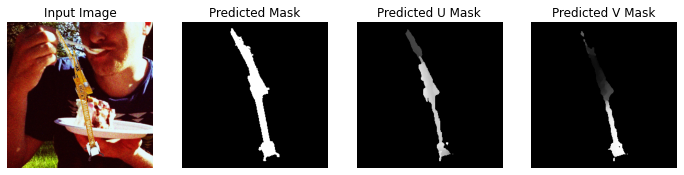

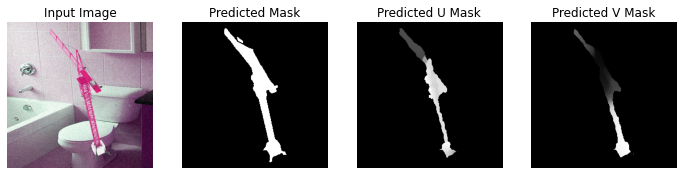

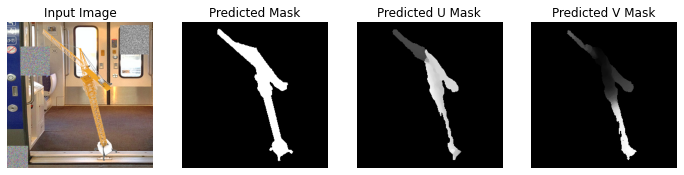

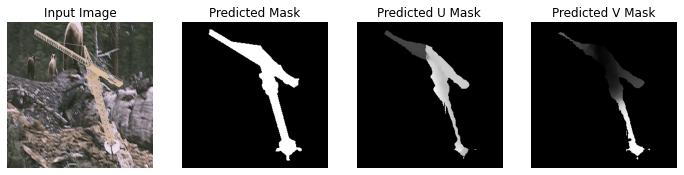

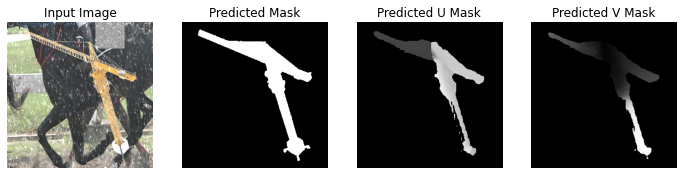

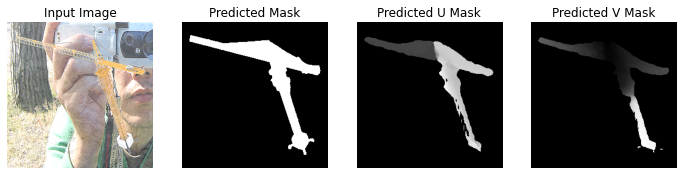

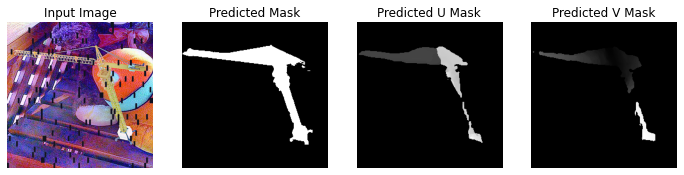

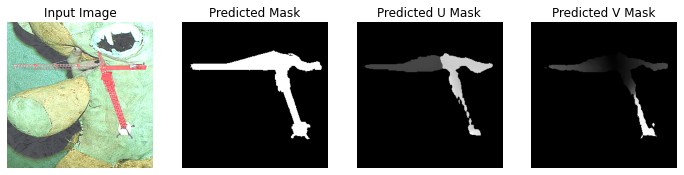

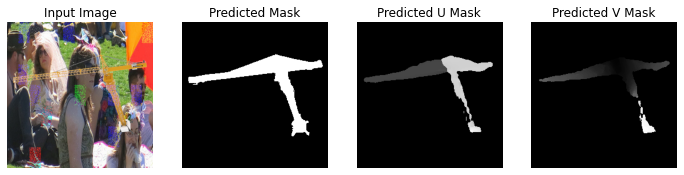

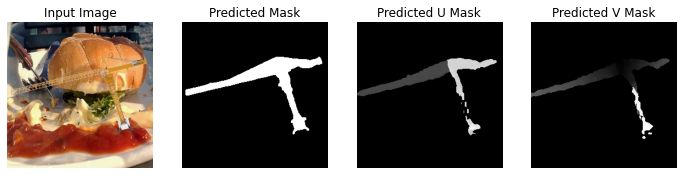

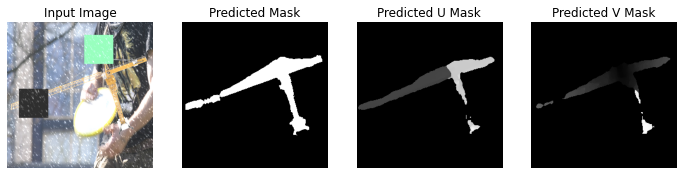

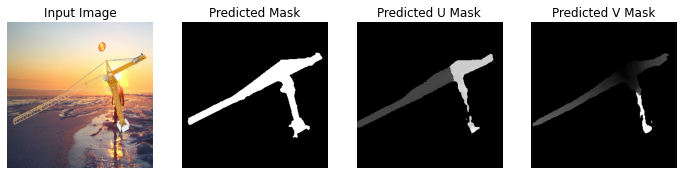

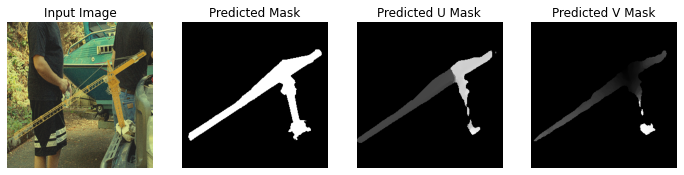

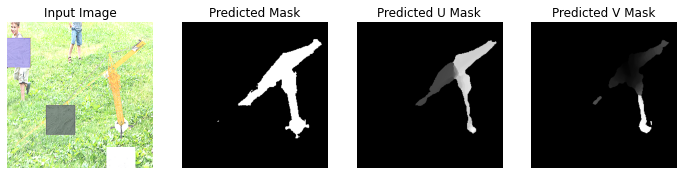

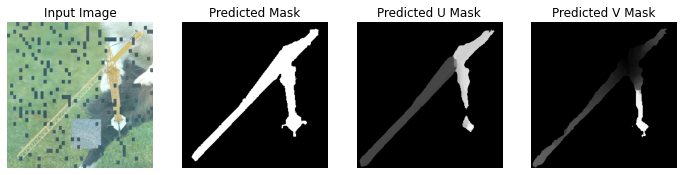

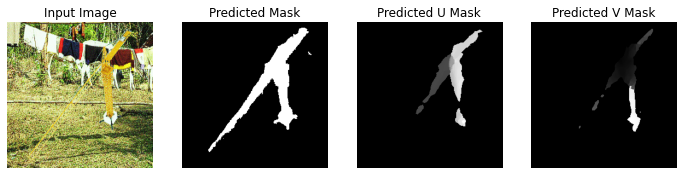

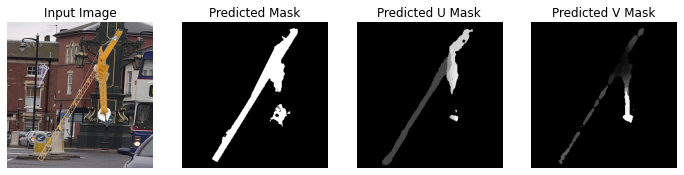

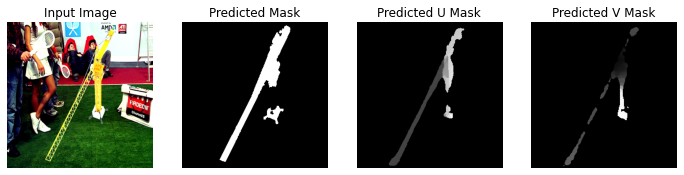

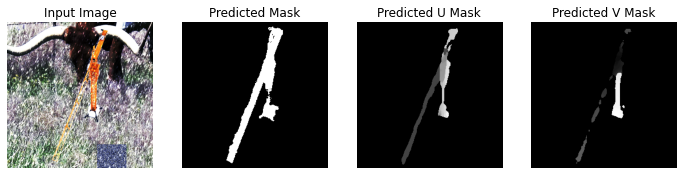

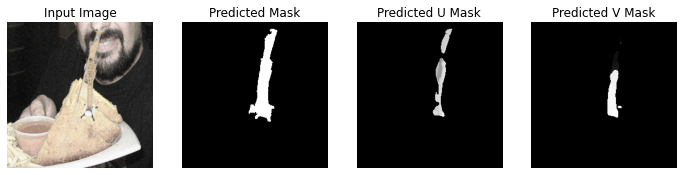

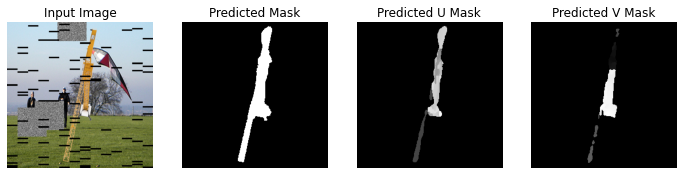

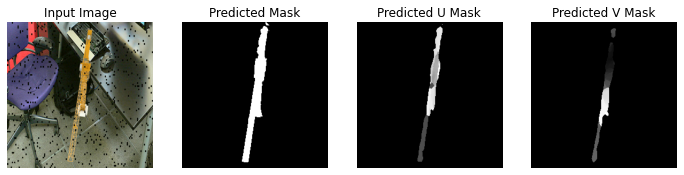

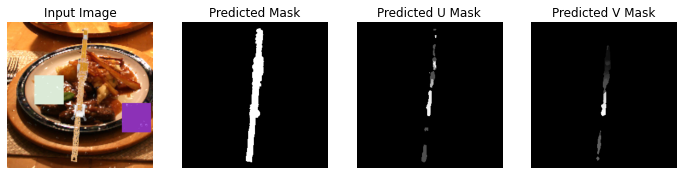

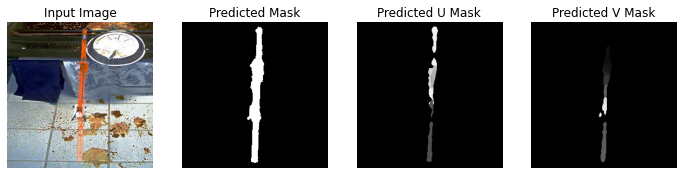

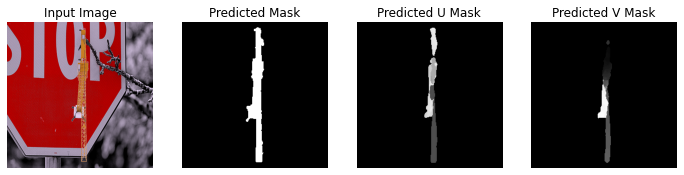

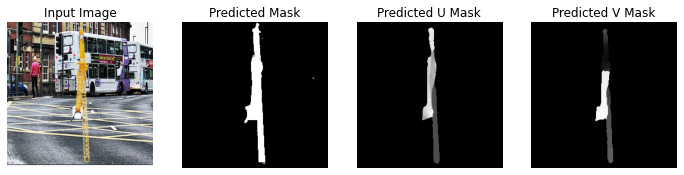

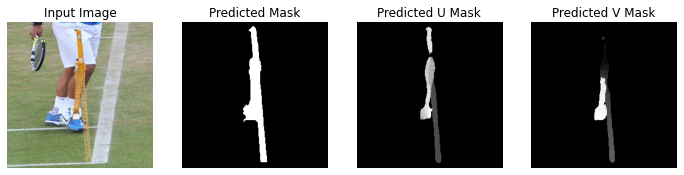

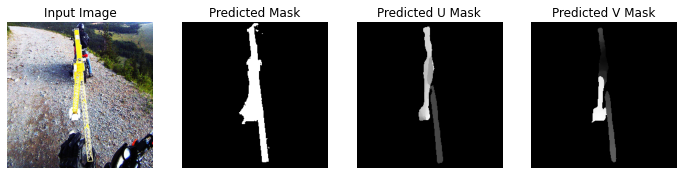

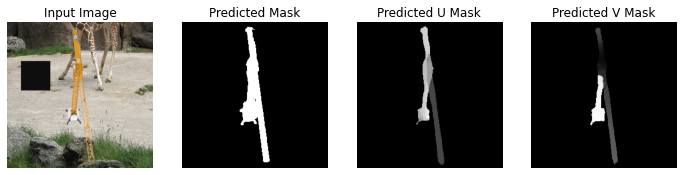

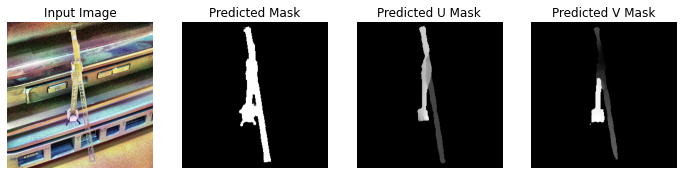

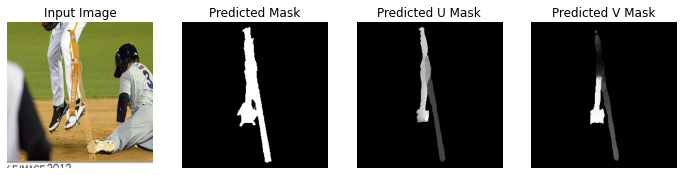

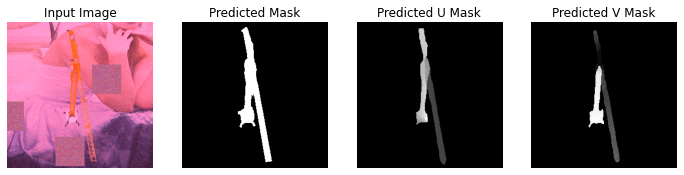

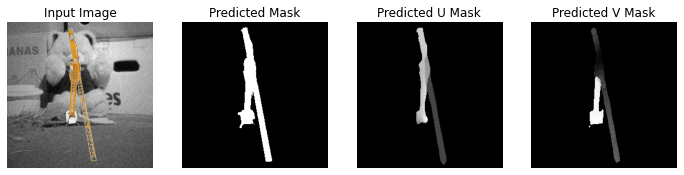

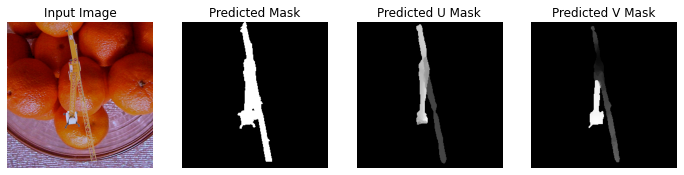

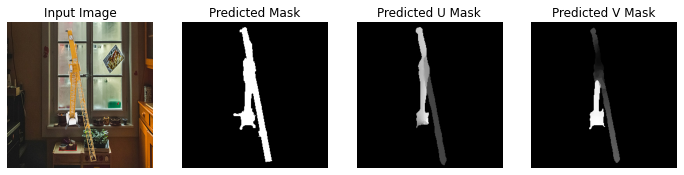

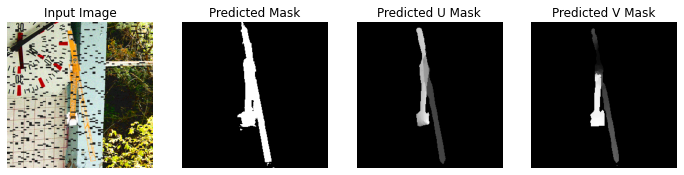

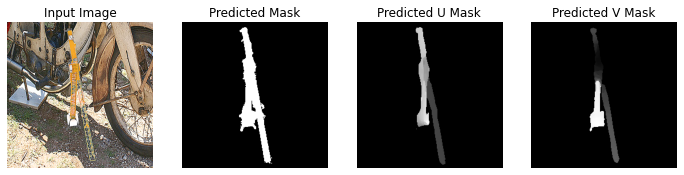

In [22]:
for path in train_image_paths[:50]:
    visualization(model, path)

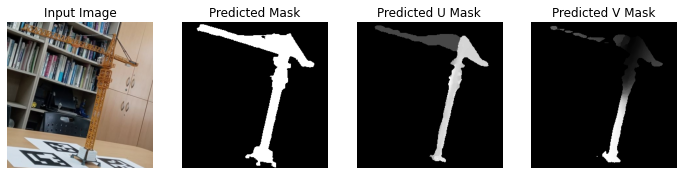

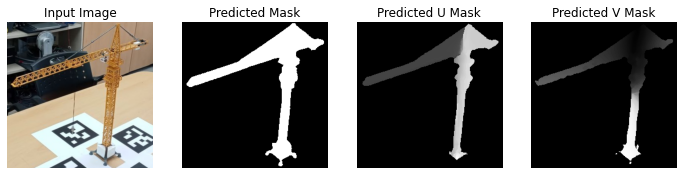

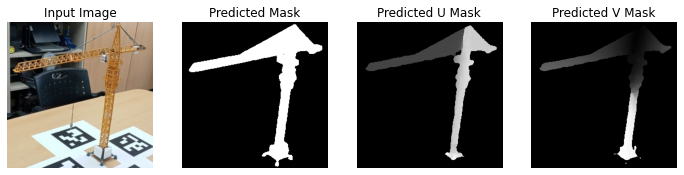

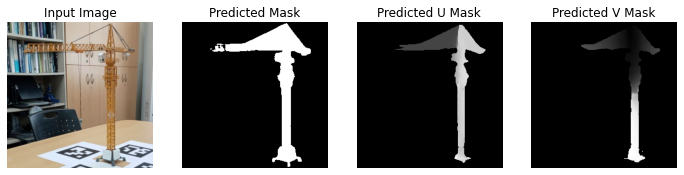

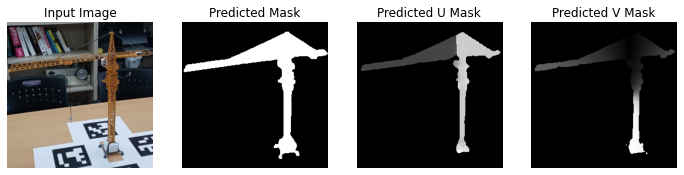

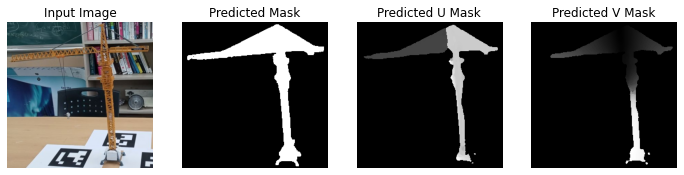

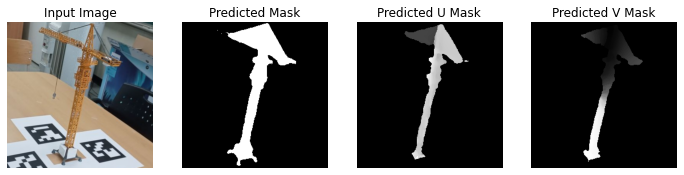

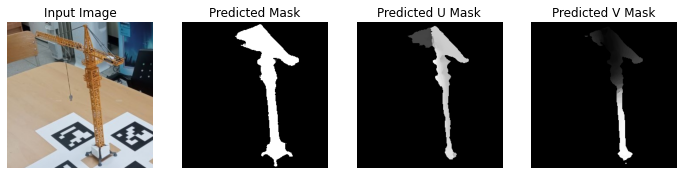

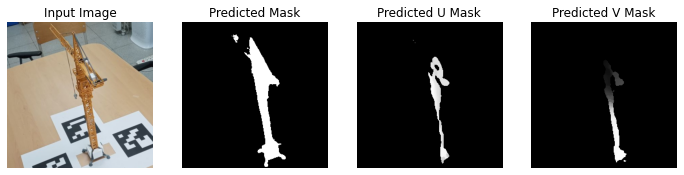

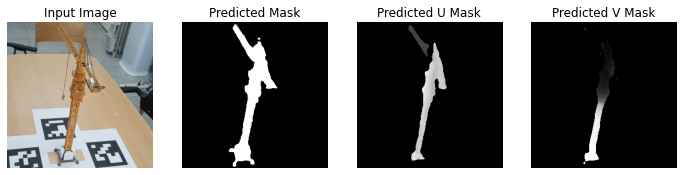

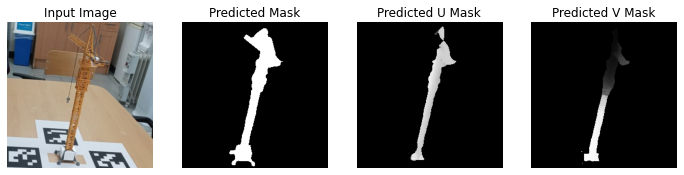

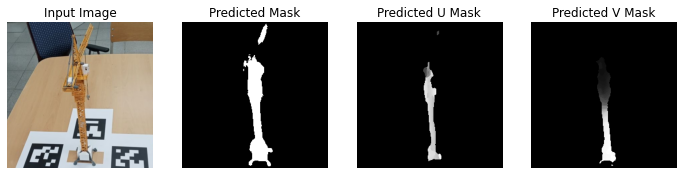

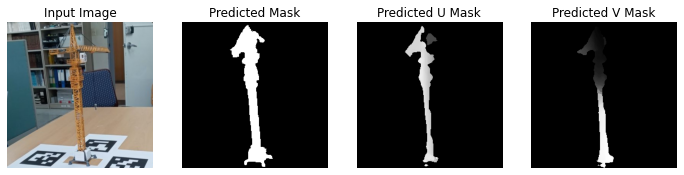

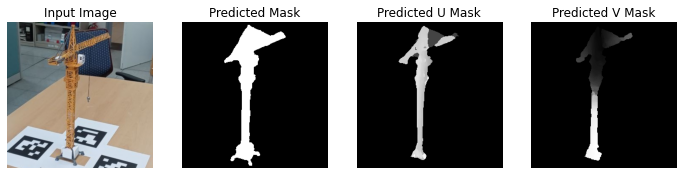

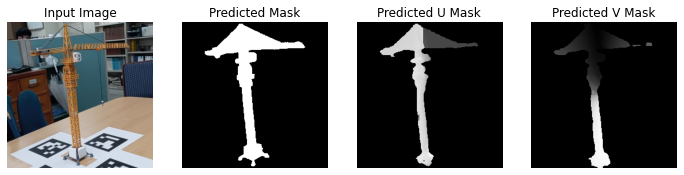

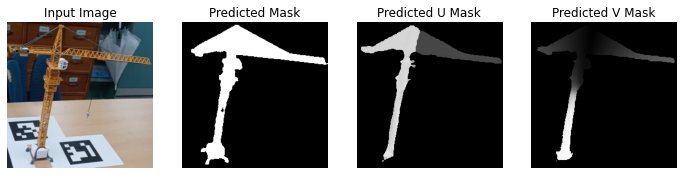

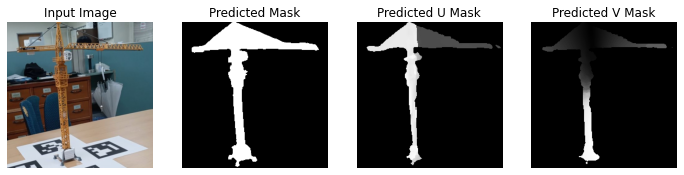

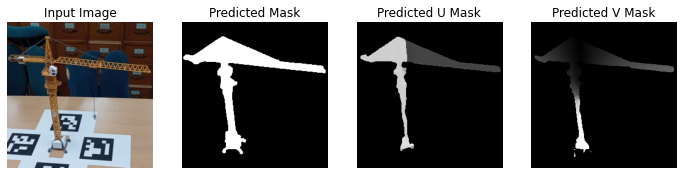

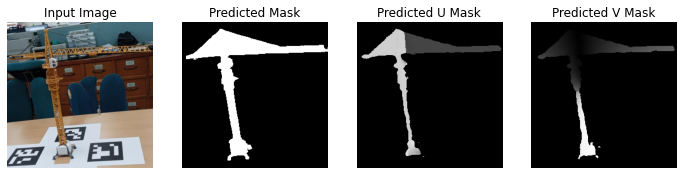

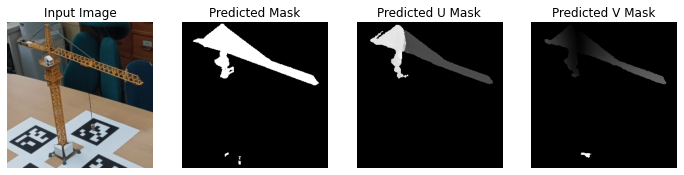

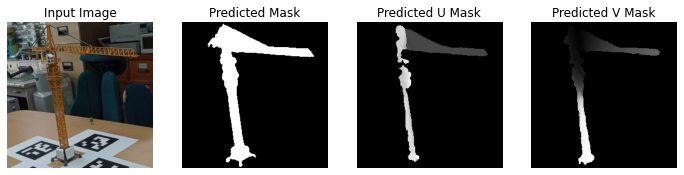

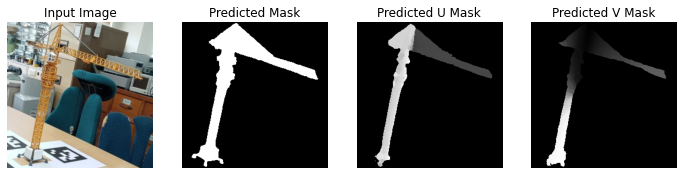

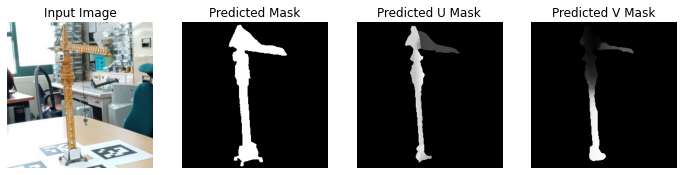

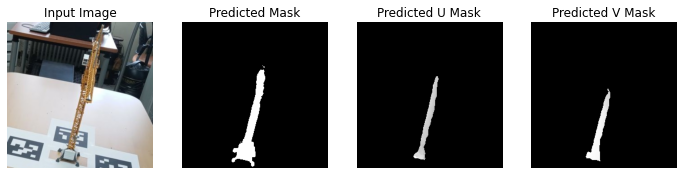

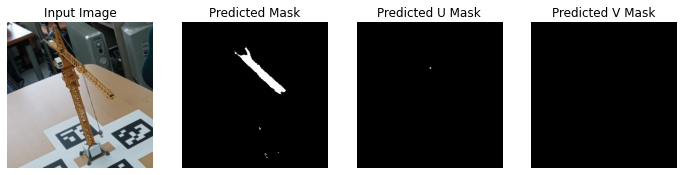

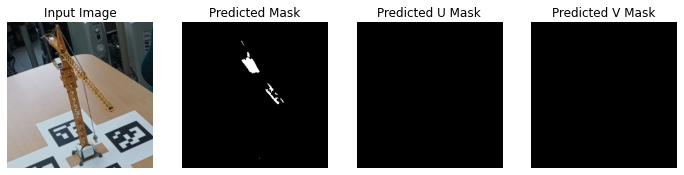

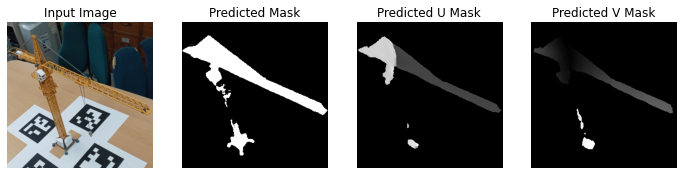

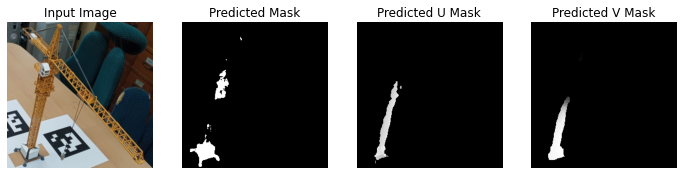

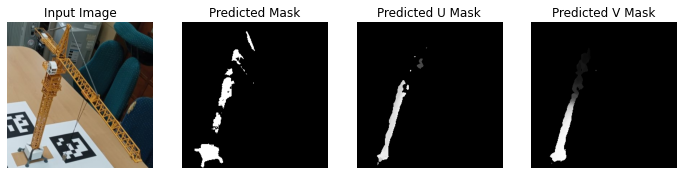

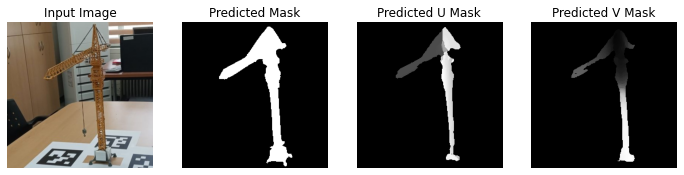

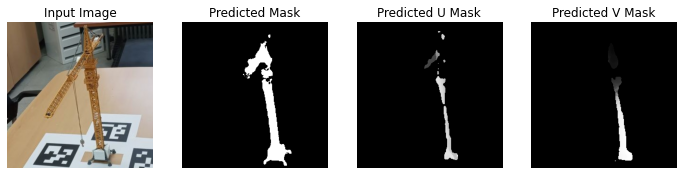

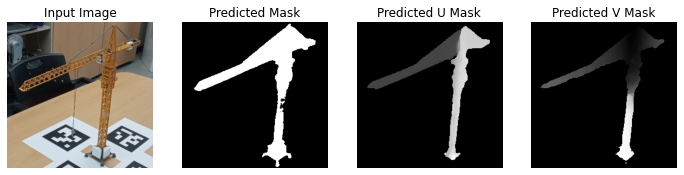

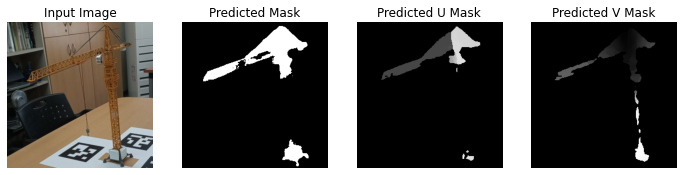

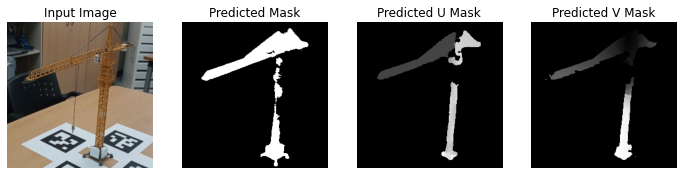

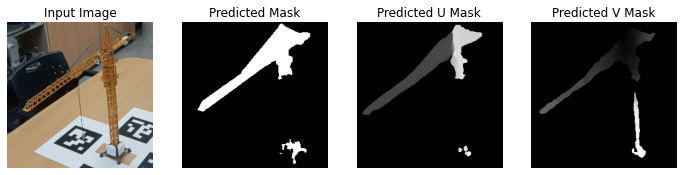

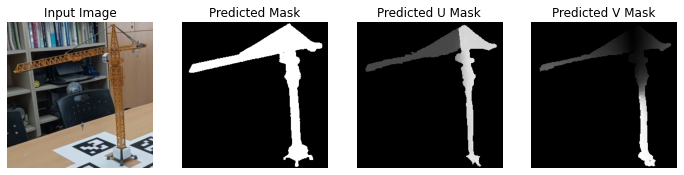

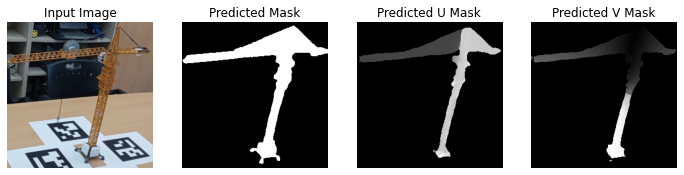

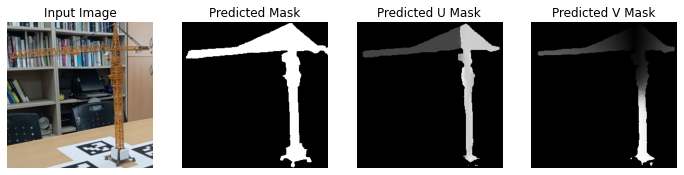

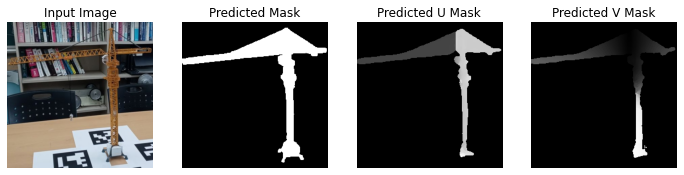

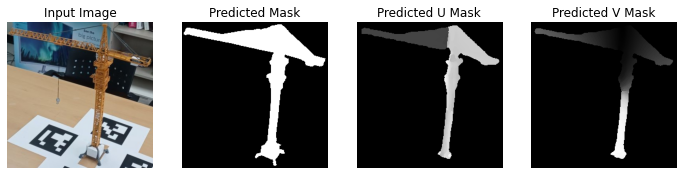

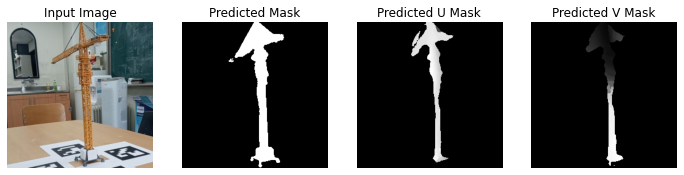

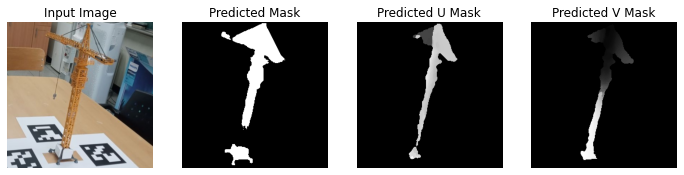

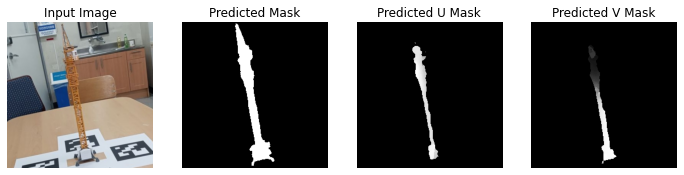

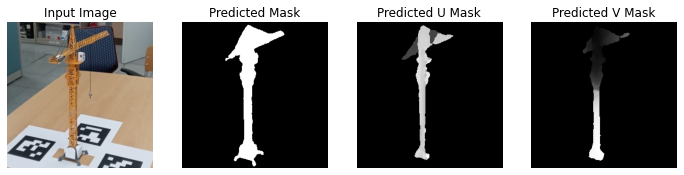

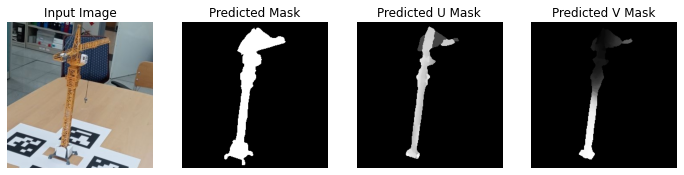

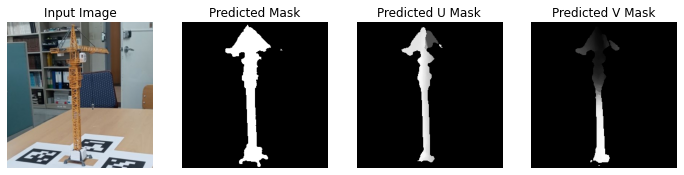

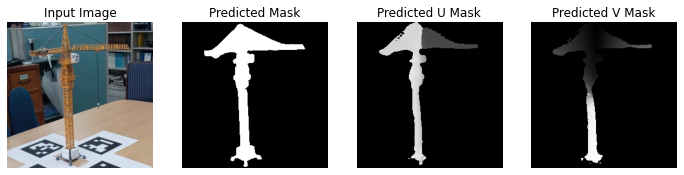

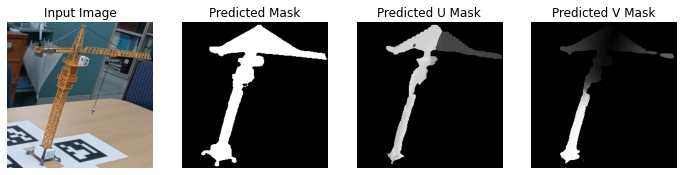

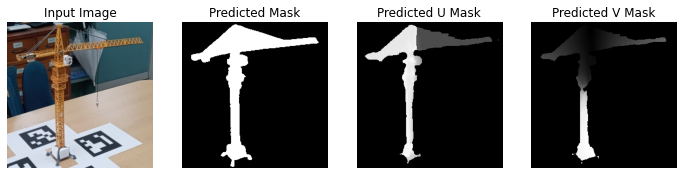

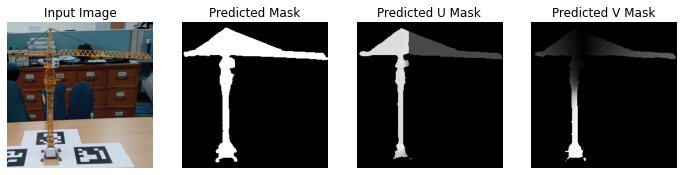

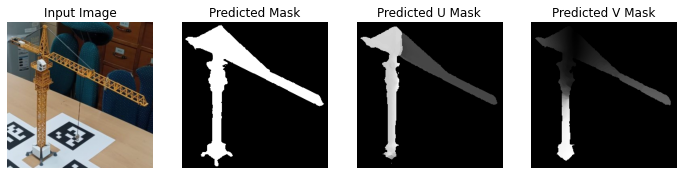

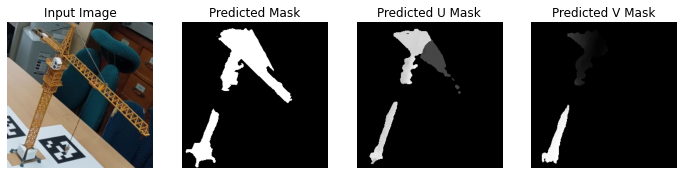

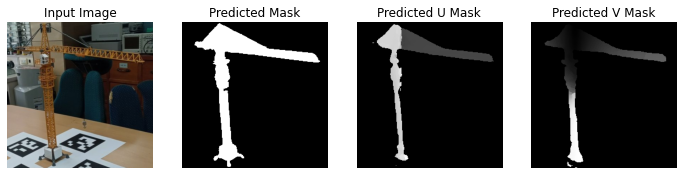

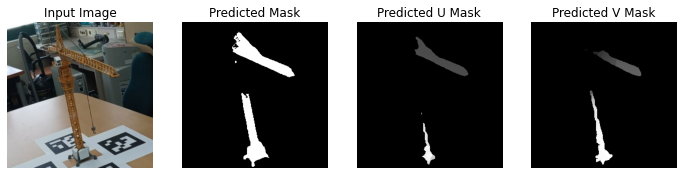

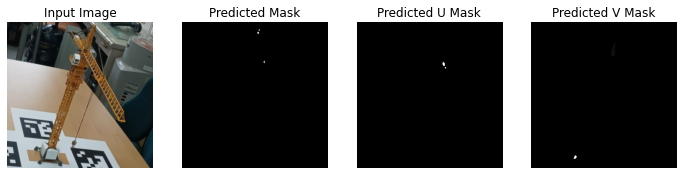

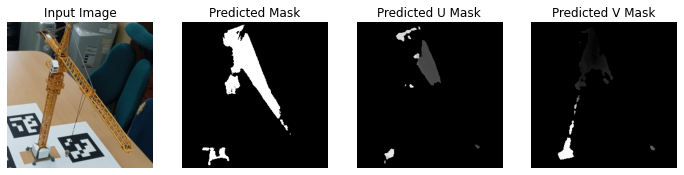

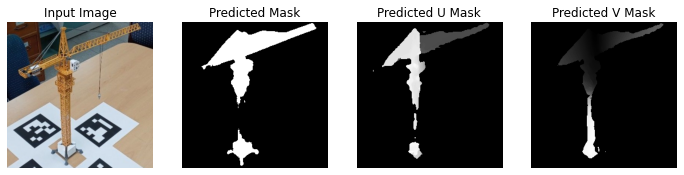

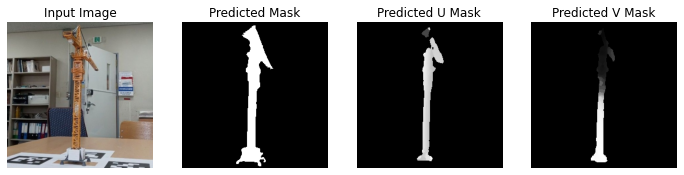

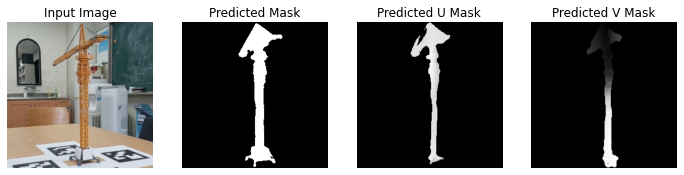

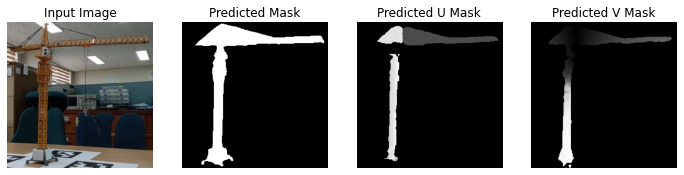

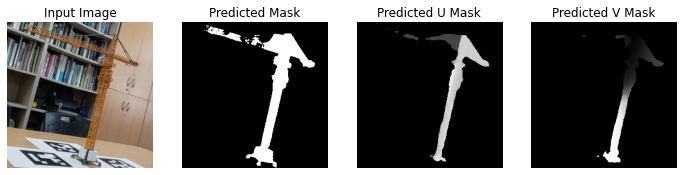

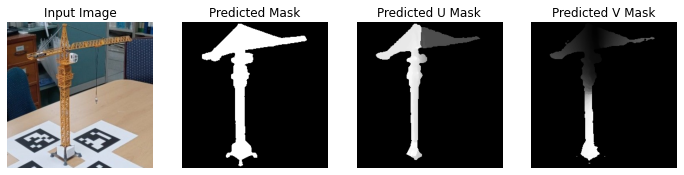

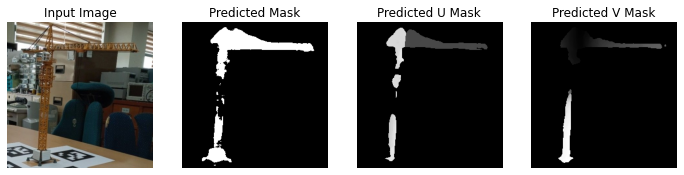

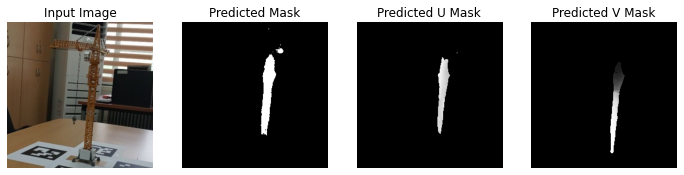

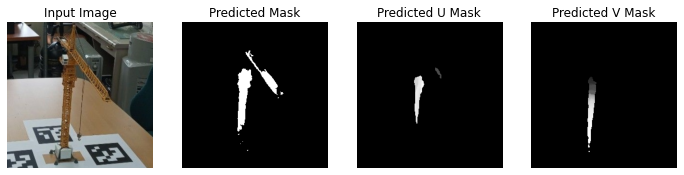

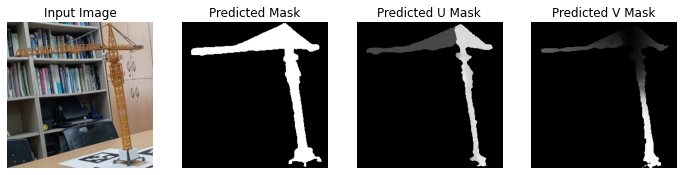

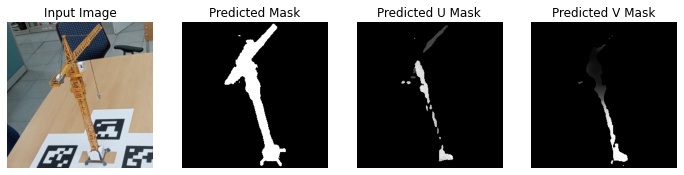

In [23]:
test_path = glob('C:/Users/IVCL/Desktop/crane/real_image_crop/*.png')
for path in test_path:
    visualization(model, path)

In [21]:
mask = F.interpolate(mask, 512)
u_mask = F.interpolate(u_mask, 512)
v_mask = F.interpolate(v_mask, 512)

In [22]:
temp = torch.argmax(mask, dim=1).squeeze().cpu()
upred = torch.argmax(u_mask, dim=1).squeeze().cpu()
vpred = torch.argmax(v_mask, dim=1).squeeze().cpu()

coord_2d = (temp == 1).nonzero(as_tuple=True)

coord_2d = torch.cat((coord_2d[0].view(
    coord_2d[0].shape[0], 1), coord_2d[1].view(coord_2d[1].shape[0], 1)), 1)
uvalues = upred[coord_2d[:, 0], coord_2d[:, 1]]
vvalues = vpred[coord_2d[:, 0], coord_2d[:, 1]]
dct_keys = torch.cat((uvalues.view(-1, 1), vvalues.view(-1, 1)), 1)
dct_keys = tuple(dct_keys.numpy())
dct = load_obj("./UV-XYZ_mapping")

In [23]:
fx = 595.259627
px = 255.312872
fy = 551.317594
py = 223.823052

intrinsic_matrix = np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]])

camera_rigid_transformation = np.array([[ 0.9999970197677612, -8.742251367266363e-08, -0.00243386160582304, 0.006821606773883104],
        [-8.742275525719378e-08, -0.9999997615814209, -1.3877781190369556e-17, -0.018590735271573067],
        [-0.0024338611401617527, 2.1277490880322603e-10, -0.9999967813491821, 0.09084007143974304],
        [0, 0, 0, 1]])
mapping_2d = []
mapping_3d = []
for count, (u, v) in enumerate(dct_keys):
    if (u, v) in dct:
        mapping_2d.append(np.array(coord_2d[count]))
        mapping_3d.append(dct[(u, v)])
# Get the 6D pose from rotation and translation matrices
# PnP needs atleast 6 unique 2D-3D correspondences to run
if len(mapping_2d) >= 4 or len(mapping_3d) >= 4:
    _, rvecs, tvecs, inliers = cv2.solvePnPRansac(np.array(mapping_3d, dtype=np.float32),
                                                  np.array(mapping_2d, dtype=np.float32), intrinsic_matrix, distCoeffs=None,
                                                  iterationsCount=300, reprojectionError=1.0, flags=cv2.SOLVEPNP_P3P)

In [24]:
ry = (R.from_euler('y', 90, degrees=True)).as_dcm()
rz = (R.from_euler('z', 90, degrees=True)).as_dcm()
rx = (R.from_euler('x', 90, degrees=True)).as_dcm()
rvecs_dcm = R.from_rotvec(rvecs.squeeze()).as_dcm()
rigid_transformation = np.append(rvecs_dcm, tvecs, axis=1)
rigid_transformation = np.append(rigid_transformation, [[0,0,0,1]], axis=0)

In [25]:
rigid_transformation_rf = inv(camera_rigid_transformation) @ rigid_transformation

In [26]:
# blender
R.from_dcm(rz@rigid_transformation_rf[:3,:3]).as_quat()

array([0.82922494, 0.03780372, 0.51317383, 0.21819601])

In [93]:
# real
R.from_dcm(inv(rz)@inv(ry)@rz@rigid_transformation_rf[:3,:3]).as_quat()

array([ 0.06782948, -0.24822175,  0.5431995 ,  0.79919924])

In [94]:
rz@rigid_transformation_rf[:3,3]

array([ 0.21039609,  0.25722592, -0.74037724])